In [1]:
import os, pickle, time, re, itertools

import helpers

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

# ignore warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)

## Data Prep

In [3]:
# read in complete labeled data set
df = pd.read_csv('../datasets/PowerShellCorpus.ast.csv')

# split into target variable and input features
paths = df.Path
y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# split off 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# check the obf/non-obf labels for this training set
df.groupby('Label').count()['Path']

Label
0    7374
1    7328
Name: Path, dtype: int64

In [4]:
# from BorutaShap import BorutaShap
# Feature_Selector = BorutaShap(importance_measure='shap', classification=True)
# Feature_Selector = pickle.load(open("boruta-shap.bin", "rb"))
# Feature_Selector.accepted

# results in the following "Accepted" features:
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
print(f"Number of features selected from Boruta-Shap: {len(boruta_shap_accepted_features)}")
X_train_boruta_shap = X_train[boruta_shap_accepted_features]
X_test_boruta_shap = X_test[boruta_shap_accepted_features]

# remove "Json" style named features for some of the algorithms that don't like the feature names
X_train_boruta_shap = X_train_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_boruta_shap = X_test_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Number of features selected from Boruta-Shap: 446


## Original Revoke-Obfuscation Model Evaluation

In [5]:
# Instantiate a logistic regression using the original model parameters from Revoke-Obfuscation
# This functions as our baseline.
#     Original coefficients: https://github.com/danielbohannon/Revoke-Obfuscation/blob/master/Revoke-Obfuscation.psm1#L510
#     Reference: https://stackoverflow.com/questions/24438779/creating-a-sklearn-linear-model-logisticregression-instance-from-existing-coeffi
lr = LogisticRegression()
lr.coef_ = np.array([[-4217.0000, 4076.5585, -350918.0000, 77447.5892, -3002.5000, -22984.7197, -23885.5079, 26376.7328, 1352.0000, -608.9274, -12721.5000, -3720.4697, 54935.0000, 15304.8156, 56435.5000, 11551.4227, 32070.0000, -27850.5045, 363390.4960, 48386.7596, 86796.4960, 115933.7263, -142831.0000, -19778.0061, 27639.5000, -16901.6964, -112857.0000, -18112.9123, 36851.0000, 26375.9568, -42031.5000, -12559.1599, 68426.5000, -18339.7905, 11003.5000, -53896.8043, 67648.0000, -17532.5011, 23215.5000, 36132.7856, -69678.5000, -25248.0458, 38203.5000, 11361.4763, -240334.0000, -38771.9378, 49142.5000, 64353.4157, 10302.4960, 406.4446, -34459.5000, -2955.8546, 21300.9960, 2941.5979, 5791.0000, 1330.2587, 36602.0000, 2619.8913, 12664.5000, 4416.3735, -100050.0000, -37366.5084, 5710.0000, 2633.9551, 158147.9603, -18158.4740, 161825.9722, -20001.9312, 64935.0000, -43777.5056, 31906.5000, 13462.1346, 60106.5000, 7133.7619, 40188.5000, -14606.4479, 54331.5000, -29268.7191, 149030.5000, 26262.2372, 8987.5000, 15514.3012, 86613.5000, 37693.3862, 187087.5000, 2204.9358, 27173.9960, 486.4059, 0.0000, 0.0000, -8004.5000, -217.8750, -55554.5000, -31207.3051, 0.0000, 0.0000, 0.0000, 0.0000, -72100.5000, 86486.3632, -88222.0000, 41537.6909, 0.0000, 0.0000, -2667.5000, -27812.5092, -107955.0000, -8038.1221, 23575.0000, -3766.3804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 13134.5000, 59394.3285, -351454.5079, -45218.3629, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -42456.5000, -29448.2914, -137057.0000, -36669.7391, 0.0000, 0.0000, 0.0000, 0.0000, 29407.5000, -7420.5964, 70425.0000, -8844.7808, 0.0000, 0.0000, -48852.0000, 21308.9596, -1675.0000, -1933.1864, 48472.0000, -28527.1497, -97878.0040, -47333.7029, 3547.0000, 522.4471, 10310.5000, -8538.2819, 15427.0000, -4334.7155, -6519.0000, -17989.5282, -32726.0000, 28561.3750, 4784.0000, 80642.3300, -12982.0000, -31347.0188, 1614.0000, -12886.6517, -112068.5040, 57295.8071, 33703.9960, 11522.2887, 81468.4960, -33591.6668, 0.0000, 0.0000, 0.0000, 0.0000, -27937.0000, 26070.8949, -103030.5079, -4833.0293, -1363.0000, -2307.2810, 20645.4960, -14011.9169, 27957.5000, 320.5283, -18510.5000, 795.1956, 77451.0000, 37640.6490, -61290.0040, -72043.3138, 0.0000, 0.0000, -49760.0000, 55665.9162, 2852.4921, 102162.5496, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -46392.0040, -342894.6217, -27.0000, -10.1504, -189.5000, -87.7857, 0.0000, 0.0000, 0.0000, 0.0000, -141.0000, -31.6844, -2200.0000, -1916.4295, -2379.0000, -2571.2031, -33.5000, -22.9452, 0.0000, 0.0000, -163.5000, -73.6171, -5.0000, 2.2063, -58.0000, -0.4324, -131203.0238, 98853.8327, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -56215.5000, 6745.3940, 39612.4960, 29438.4945, -34547.0000, -13407.8070, 26097.5000, -10706.2602, 24924.4960, -79049.6027, 4166.5000, -3643.5382, 0.0000, 0.0000, 0.0000, 0.0000, 20618.5000, -35446.3171, -86654.5000, -16795.3228, 0.0000, 0.0000, 39911.5000, 126.9759, -21680.5000, 5683.3709, 983.5000, 26975.6571, 10814.5000, -3229.7618, 45526.5000, 32373.3740, 59797.0000, 86263.8974, 33857.0000, 2774.9499, 2687.5000, 1330.8370, 66643.9960, 2194.0103, 671.8628, 1746.9361, 2862.1353, 1826.1303, -2190.2725, -12279.1737, -14757.0354, -23920.2607, -4915.7266, -1697.7842, -9841.3088, 202986.8057, 7160.8451, -65918.6549, -40506.1549, -7782.1549, 47667.0000, -14147.6549, 5549.2654, 7313.9062, 3637.4878, 6103.5188, 2562.6387, 1210.3874, 82190.9960, -8968.6441, -5088.5000, -103464.3136, -8930.5000, 123928.6540, -903.0000, -26553.2834, 114.5000, -11250.2404, -633.5000, -15657.6612, -205.0000, -26939.4509, 16.0000, 767.1429, 1.0000, 38.6667, 29.5000, 2814.2857, 52.5000, -9315.5530, -107.0000, -336.5613, 41813.0174, 44708.2506, -6201.5000, 13943.9674, -430.5000, -5534.8641, -12809.0000, -85542.9416, -50.0000, -238.0952, 0.0000, 0.0000, 37809.5000, 7948.6253, 66643.9960, -43671.7999, 22215.0174, 59074.8887, 0.0000, 0.0000, 0.0000, 0.0000, 188394.4921, 49708.8084, 0.0000, 0.0000, -861.0000, -489.2960, 0.0000, 0.0000, 503734.5066, 7694.2607, 8.0000, 5.3333, -29374.0000, -7279.6824, -45533.0000, -9120.3508, 52239.4588, -51351.9333, 0.0000, 0.0000, 0.0000, 0.0000, -229617.4967, 35684.7944, -72045.0324, -33307.4715, 0.0000, 0.0000, -512.5000, -2993.8166, -235442.5104, -23011.2153, -10267.5000, -11294.7120, -43369.4961, 18359.2780, 1646.5000, 465.0286, 5665.0000, -1793.3380, 1823.5000, -253.1404, 3609.0000, -7437.5298, -48817.5000, -19976.1483, -50829.5000, -17631.2774, -37489.5000, -8945.3823, 136557.5091, -19439.1383, 0.0000, 0.0000, 14549.5000, 6424.2292, 1234.5000, -21033.8734, -8884.0000, 2883.9946, 141138.0005, 35698.7422, 27137.0000, 6498.5165, 41603.5039, -28973.9256, -90224.9984, -30343.5144, -69428.5000, 18854.5635, -178442.4988, 719.7524, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -19022.0326, 339682.9148, 1008.0000, 492.9424, -5696.0040, 15692.1185, -59922.2688, 26109.2759, 44230.4964, 13824.9336, 39273.4968, -38112.6181, 162393.4981, 188644.2534, -5020.0313, -66122.8954, 0.0000, 0.0000, 51444.5000, 17580.0844, 0.0000, 0.0000, -35325.5040, 15382.3826, -5541.2609, 34412.0748, -147627.0090, -42099.6217, 0.0000, 0.0000, 0.0000, 0.0000, -164610.4984, -55498.8924, -384713.5666, -17331.0358, 158672.0000, 31278.3195, -17229.0000, -7847.8578, -32420.0000, -8638.7993, 6359.0000, 3770.1574, -36988.0000, -11063.6639, -53220.5000, 5550.4490, 10157.0000, 2314.6943, 41442.4915, -56971.5828, -149545.9980, -23737.2204, 0.0000, 0.0000, -127.5000, -254.7540, 1.0000, 1.2500, 983.0027, -201889.1027, 9816.5000, 17933.6860, -6643.0000, -78056.9415, -15346.0000, -185784.7864, -7852.0000, -71891.4698, 7400.5000, -72026.7151, -1399.0000, -15726.2163, 0.0000, 0.0000, 741.5000, 22249.9594, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 120.5000, 8825.0000, 0.0000, 0.0000, 2943.0000, 4400.8040, -658.0000, -3913.4191, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 442.0000, 295.9936, 6023.5000, 16542.0177, 0.0000, 0.0000, -13830.0000, 49388.8319, -38612.5000, -169493.9107, 107842.5000, 38212.6137, -4651.5000, 7987.8186, 10482.4971, -5134.7769, -8629.5000, 97987.3390, 8396.0000, -86860.9262, -1396.0000, -1177.7675, -4397.0000, 80020.3827, -44792.5000, 50424.2713, -37972.5000, -83002.0634, 25592.5000, 47183.7918, 37484.5004, 35828.4140, 13714.5000, -41067.5400, -1174.5000, -4621.8717, 1358.0000, -3824.5578, 13909.0000, -30059.2334, 4119.5000, -206541.3146, -22404.0000, -248169.0645, -9096.5000, -156959.2388, 16960.0000, 114072.4059, 27428.0000, 141148.9742, -80322.5000, -8875.7352, -57731.0000, -187172.1326, 8355.0000, -33260.7589, 574693.0091, 34174.2647, -5747.0000, 47249.9735, 31.5000, 64.6127, 85.0000, 125.0000, -1754.0000, -12322.1245, 21.0000, 10.2439, -3138.5000, -198.7675, -21964.5000, -5011.8652, -4602.0000, -2866.7171, -17270.5000, 21653.0595, -39377.5160, 18118.8755, 8363.0004, -202771.0862, -2537.0000, -320.3458, -2904.0000, -424.0460, -2776.5000, -3432.9937, -3601.5000, -327.1050, -89464.9996, -15010.0004, 43651.0000, 13923.3471, 176098.5000, 15354.1726, -1632.0000, -103.7618, 15764.4984, -12754.6260, -8127.5000, 101401.8747, -19870.0000, -4407.9192, -26987.5000, -22516.8122, -18753.0000, 6777.4776, -13.5000, -7.2193, 125555.5000, 32368.4850, -13012.5000, -3663.9897, -230711.5171, -25277.7594, 548842.5000, 284902.0829, -6453.0000, -2985.7124, -576.0000, -117.1755, -6431.0000, -2996.2890, -118.5000, -73.8828, -45540.0000, -6373.8673, -153687.5000, -23915.8132, 1492.5000, 4546.2503, -5717.5000, -39161.3268, -117451.0000, -561.3454, -18474.0000, -2191.8046, -17529.0000, -4771.7738, -28524.5000, -7733.0232, -49564.0000, -2121.4370, -51435.4992, 6818.4114, -48880.0000, -628.1581, -50747.0000, -1402.8815, -44169.0000, -648.9401, -46776.5000, -453.6758, -133693.5000, -20354.4592, -110006.4988, 25759.7033, 0.0000, 0.0000, -64179.0000, 34949.7360, 200911.9795, 88323.7974, 0.0000, 0.0000, 0.0000, 0.0000, -73076.0040, -17445.4047, -76322.5151, -50983.9260, 0.0000, 0.0000, -12731.5000, -2096.1225, -171646.5071, 53958.3341, -52018.4961, -120062.4226, 1831.5000, 9639.4737, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1831.5000, 9639.4737, 55222.5000, 16670.5238, 204543.9368, 75883.9633, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -113950.0000, -41752.5072, -121202.4999, 47437.3867, 0.0000, 0.0000, 0.0000, 0.0000, -49778.5078, 53871.0559, 107623.4894, -108713.0842, 0.0000, 0.0000, -101901.4988, -52322.0672, 177350.0051, 5145.3998, 165262.0039, 26093.6394, -92724.5093, -97773.3014, 48442.5000, 32390.1340, -95747.5040, -7893.8505, 5200.0000, 4986.9400, 31273.5039, -23860.0069, -147706.0000, -14914.3940, 72208.4915, 132803.3074, -12999.0000, -2123.3276, 67316.4962, 92896.3010, 231363.9914, 36137.9705, 38848.9960, 40961.1102, 72588.9963, -185652.6378, 0.0000, 0.0000, -1941.0000, -240629.8538, -72944.5040, -15062.5849, -35801.4986, -72384.3526, 119506.5012, -68347.8922, 13891.5001, -4229.0073, -188886.5000, -18240.7468, -18945.5000, -9757.3795, 96550.0039, -23240.9283, -83233.5272, -35970.7262, 0.0000, 0.0000, 7324.4921, 23325.2308, 167336.4979, -61315.0215, 0.0000, 0.0000, 0.0000, 0.0000, -8.5000, -12.3188, -50988.5000, -6420.7954, -271.5000, -90.2700, -72.0000, -14.1896, 0.0000, 0.0000, 0.0000, 0.0000, -133.0000, -43.3247, -250.5000, -90.6177, -476.5000, -206.8010, -128.5000, -46.3626, 0.0000, 0.0000, -2101.5000, -1506.2802, -9.5000, -11.0465, -201.0000, -54.3353, 167117.9661, -56843.3717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 213207.9973, 12626.8609, -51791.5229, -136642.0849, -3991.0000, -719.7766, -28977.0000, 3877.3964, -68222.0117, -104157.1725, -12719.5000, 44352.6597, 0.0000, 0.0000, 0.0000, 0.0000, 268990.0000, 69969.2195, 145410.5000, -55642.9431, 0.0000, 0.0000, -76883.0067, -54230.2973, 69947.4961, 83079.8315, 44797.5000, 9072.6208, -68566.0000, -2162.6419, -6201.0000, 9121.0343, -84569.5000, -66842.4105, 473.5000, -2278.9042, -12855.5000, -25906.6861, 52239.4588, -5958.3521, -5985.2167, -5985.2167, -5812.7022, -5985.2167, -172.5145, -12861.5314, -7432.9263, -12944.0441, -23976.1418, 16245.6557, 16543.2155, -4871.7088, -84420.0443, 33009.0221, 33476.5251, 90894.5211, -117896.5694, 49351.7337, 6732.1589, 7925.9692, 9139.0043, 5435.0819, 8784.0331, 2490.8873, -786.0000, -135.7384, -4369.0000, -2146.0597, 0.0000, 0.0000, 7326.0000, -244.2695, -103.5000, -9.1512, 0.0000, 0.0000, 744.5000, -78.3806, 744.5000, -78.3806, 41.5000, 4.4196, -396.0000, -168.8610, 885.5000, -2456.6036, -269.0000, -43.0331, 738.0000, 305.1140, 0.0000, 0.0000, 1375.5000, 12391.5685, 2.0000, 1.7857, 2144.0000, 296.4426, -46774.0000, -4975.7126, 2144.0000, 296.4426, 0.0000, 0.0000, 501.5000, -1234.8288, 3905.0000, -542.9068, -5430.5000, -4386.0833, 33.5000, 59.3694, 276.0000, 121.4256, 0.0000, 0.0000, 276.0000, 121.4256, 0.0000, 0.0000, 650.5000, 2.5843, 0.0000, 0.0000, 725.0000, 548.4234, 0.0000, 0.0000, -4523.0000, -416.4257, -198.5000, -279.4521, -4954.0000, -474.9834, -433.5000, -235.7917, -1360.5000, -95.1978, -153.0000, -68.7836, -4.5000, 14.6603, -98.0000, -26.8160, -4782.5000, -254.0460, -68.5000, -80.2815, -10164.5079, 5810.6264, 173304.9891, -62384.9929, 0.0000, 0.0000, -7155.9961, -3885.2244, -22481.5086, 30374.2156, 0.0000, 0.0000, 0.0000, 0.0000, -15316.9999, 14379.1513, -12460.0056, 61.8604, 0.0000, 0.0000, 0.0000, 0.0000, -61018.5000, -61604.4930, -11454.9882, -5208.5133, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -2386.0000, 5141.6249, -62543.0405, -44232.1232, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 16244.4932, 26253.0316, 3906.9943, -60376.6681, 0.0000, 0.0000, 0.0000, 0.0000, 180.5000, -9605.9002, 98001.9881, 25057.6794, 0.0000, 0.0000, 2865.0000, -9530.6970, 128191.0079, -79365.2414, -41207.0000, -16366.3433, -16997.5251, 64437.6020, -402.5000, 79.2478, -32644.5000, -19751.6188, -12871.0000, -7339.1972, 4479.4943, 16550.0622, -11893.5040, -41770.4752, 47185.9960, -48456.8594, 0.0000, 0.0000, 139017.4874, 37106.6988, -136545.0126, -32107.2931, -57667.5000, 41270.4745, -118002.5078, 190459.7337, 0.0000, 0.0000, 0.0000, 0.0000, -24995.5000, 13960.8348, 39716.0039, -20329.8211, -24715.5040, -119039.5205, 122276.9857, -94486.3966, -32997.0000, -107533.5064, -11620.9999, -36885.9910, 32546.0000, -23255.4933, -107630.5200, -78619.0866, 0.0000, 0.0000, -79843.5057, -45009.1880, 43195.9686, 68493.1735, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1722.0000, -213.0043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -35615.0000, -2351.0080, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -108963.0126, 1065.1157, 237513.9778, -36941.3698, 0.0000, 0.0000, -311.5000, -37967.6392, 9844.9961, 147435.6048, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 65951.5000, 81705.6929, -78302.0000, -34407.0846, 0.0000, 0.0000, 23211.5000, -12600.2724, -85548.0000, -16584.9095, 7951.5000, -1879.6440, 31876.9960, 8168.0877, -3689.5000, -5472.5484, 45222.4953, 995.4257, -1847.5000, -1251.8610, -13419.0000, -2025.0848, -72045.0324, -4015.7678, -4019.5024, -4019.5024, -4006.7970, -4019.5024, -12.7054, 8013.1118, 18975.0105, 7941.5842, 9924.5685, 1706.5085, 9050.4421, -2923.7944, 1165.9527, -34851.5170, 28214.4857, 16576.4687, -27048.5330, 15120.7354, -5406.0535, -14477.6501, -3813.4209, -2661.4471, -4766.1196, -11816.2031, -37185.0000, -8437.3588, -40884.5000, -6794.9032, -48941.4964, 170618.1916, -110440.4976, -13044.4818, -24304.5000, -2358.5792, 1664.0000, -1769.4345, -36565.5000, -10533.7847, -43317.0000, -12477.3564, 109813.0000, 1374.8953, -61734.2500, 409.3292, -11032.2500, -71825.6653, -122693.7500, -28759.7479, -204302.2500, -14464.1837, 77562.0000, -2500.0088, 39977.5000, -1303.4766, 77616.5000, -1488.8287, -59264.5000, -4860.2913, -139886.5000, -1540.7090, -59799.0000, -3817.4242, 22734.5000, 1611.8041, -160326.0000, -12369.5944, 3332.2500, -17571.2553, 165476.0000, 24423.9924, -7328.5000, -5952.9037, 316946.7500, -6035.5864, 130329.0000, -9298.4555, 317753.7500, -13545.0009, -40698.0000, 9288.3108, -33731.5000, -20222.6042, 139661.2501, 34361.3069, -168896.7500, 84301.0371, 229835.7501, 35410.5494, -170293.5000, -41054.0702, -81213.4988, -8853.2501, -94670.4988, -41823.0957, 15002.5000, -7219.7348, -8812.5000, 1820.4115, 47851.5000, 19667.8130, -11568.0000, -22348.3947, -17160.5000, -6318.2706, 25354.0000, -818.3695, -62130.0000, -2464.7560, -3392.5000, 4397.0757, -52732.4976, -186823.4881, 0.0000, 0.0000, -49492.0000, 8260.7376, 127702.7500, -58360.9455, 0.0000, 0.0000, 0.0000, 0.0000, 80618.2500, 31231.8460, 272379.2471, 96801.4454, 0.0000, 0.0000, 164627.5000, -66189.7195, 94813.2539, -2228.0598, 52383.2500, -48763.2717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -224750.5000, -36484.9437, 291425.2531, -47532.4768, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -131.0000, -60.9302, 67450.0000, -22906.3276, 101053.7496, 14247.7563, 0.0000, 0.0000, 0.0000, 0.0000, 71326.5000, -23759.0491, -195406.0000, -72403.8205, 0.0000, 0.0000, 36708.7500, -20507.9635, 122147.5000, -52614.2131, -30274.7461, -38591.6714, 280959.7535, -8396.3696, -889.0000, 691.0561, 43752.0000, -8189.7425, -81321.5000, 7613.5143, -58647.2500, -3625.1276, 22186.0000, -2961.3794, 150150.7496, 29831.3633, 329531.0000, -52370.5268, -92096.0000, -964.9300, -14362.7476, -88474.6270, -75909.0000, -22627.0451, 42606.7496, 31713.4313, 0.0000, 0.0000, 0.0000, 0.0000, 18990.0000, -10369.0641, 85862.9971, 30202.7383, 40866.5000, 4227.4575, -42388.2500, -104092.9893, 32168.5000, 132.9601, -54184.7500, -3552.2871, -92069.5000, -28045.6090, -34491.0029, 3344.8714, 0.0000, 0.0000, -89281.5000, -3081.1435, 16015.5079, -108361.1943, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -58143.4950, 240250.8165, -19287.5000, -2909.9336, -8637.5000, -1257.2493, 0.0000, 0.0000, 0.0000, 0.0000, -122187.5000, -1826.0633, 979.0000, -522.9380, -6523.0000, -1092.1978, -7766.0000, 1837.9912, 0.0000, 0.0000, -129132.0000, -16305.4361, -10945.5000, -1173.7228, -25582.0000, -3219.1320, 138119.5062, -110213.7442, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -123407.5000, -45508.2469, 143602.9971, -96055.8059, -260899.5000, -9381.9464, -165726.0000, -18543.4041, 85005.7539, -8697.8690, 81334.5000, -108322.1951, 0.0000, 0.0000, 0.0000, 0.0000, -43965.7500, -11263.9995, -89246.0000, -23608.6866, 0.0000, 0.0000, -110825.2500, 7444.1943, -204873.0000, -13611.1478, -33702.0000, 9398.6597, -69171.0000, -13941.7828, -25736.7500, -8952.6960, -218677.5000, -33279.5400, 68887.5000, -478.0625, 85661.0000, 3622.1457, -134424.7464, -12986.7278, -15710.2217, -13145.7296, -8292.5539, -13916.6887, -7417.6678, -49121.7455, -64249.9362, -44110.0921, -24313.7199, -59809.0319, -39936.2163, 55472.8838, -24850.9903, -20280.4903, -24889.4903, -8262.9903, 38.5000, -51327.9679, -914.1580, -13013.3861, -277.8025, 3015.1268, -4649.9730, -16028.5129, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -286.0000, -696.7906, -24606.5000, -42192.7416, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -28394.0000, -20398.1656, 0.0000, 0.0000, -28394.0000, -20398.1656, 0.0000, 0.0000, -257.5000, -511.1456, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -517.5000, -176.8869, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -508.0000, -342.6830, -1592.5000, -188.4506, -5194.0000, 355.8583, -4046.0000, 1125.7153, 3328.5000, -5403.9609, -508.0000, -342.6830, 3170.0000, -5218.9740, 0.0000, 0.0000, 0.0000, 0.0000, -508.0000, -342.6830, 11903.0000, 25893.6773, -50402.0000, -42914.2734, 0.0000, 0.0000, -7477.5000, -6523.0337, 3288.5000, 4894.8993, 0.0000, 0.0000, 0.0000, 0.0000, 12580.0000, 107998.3907, -10055.0000, 111305.9500, 0.0000, 0.0000, 0.0000, 0.0000, -5651.5000, -49633.8908, 4970.5000, -3656.2528, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2327.5000, 5679.9542, 35435.0000, -102348.5052, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -10347.0000, -40929.8189, -28392.5000, -288115.0440, 0.0000, 0.0000, 0.0000, 0.0000, -7134.0000, -14055.5562, 56194.0000, -33997.6296, 0.0000, 0.0000, 25073.5000, 124467.8044, -34870.0000, 13078.7670, -7085.0000, -142936.8679, -11418.5000, 66021.5565, 0.0000, 0.0000, 4288.5000, 45716.5654, -444.5000, -281.4379, -3894.5000, -6147.2263, -6652.5000, -61542.0002, -32679.4961, -111446.6599, 0.0000, 0.0000, -2163.5000, -39591.4440, -24674.9961, 46294.2417, -1005.0000, 221.9328, -50825.5000, -115617.6576, 0.0000, 0.0000, 0.0000, 0.0000, 2562.0000, -3926.9875, -34292.0000, -98743.5910, 9726.0000, 31031.2179, -9821.0000, -20890.6581, -82.0000, -305.4839, 9333.5000, 10218.8273, 15970.0000, 68250.0325, 55914.0000, -79258.0844, 0.0000, 0.0000, 24947.5000, 19124.6134, 36156.0000, -72835.6633, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 985.5000, 9173.3165, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -82455.5000, -84373.8959, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1270.0000, 5313.4391, -49898.0000, 2153.0356, 0.0000, 0.0000, 8584.0000, 125135.9881, 8194.5000, 26365.0991, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -5103.5000, 30974.3001, 29726.5000, -9712.8222, 0.0000, 0.0000, 7075.5000, 19428.8177, -3638.5000, 26900.3796, -8345.0000, -63689.9401, 23291.5039, 35533.7205, 8.5000, 43.6954, -5319.0000, -33441.5510, 471.5000, 204.0076, 0.0000, 0.0000, -43369.4961, -5846.5614, -5814.6389, -5814.6389, -5892.6470, -5850.2282, 78.0081, -4442.1403, -5597.7203, -1960.9580, 1100.3138, -4321.7381, -6698.0341, 45447.3230, 70637.0118, 91424.5118, 64750.5118, 53249.0118, 5886.5000, -109708.4882, 2073.4897, 1556.7514, 2496.0958, 2433.3998, 2280.8668, -876.6484, -10361.5000, -17484.3346, -156574.0000, 734.6305, -32564.5000, -2294.8129, -61965.5000, -42617.9186, -6677.0000, -593.0662, -339.0000, 425.1574, -5513.0000, 2365.1457, -6655.5000, 2159.0741, 3737.5000, 30535.8254, -8562.0000, -937.5155, -59052.0118, -114050.9600, 39606.5000, -18086.4906, 112632.0001, 82842.2066, -3174.0000, -273.9189, 1070.5000, 122.1327, -7010.5000, -160324.1051, -27958.0000, -4787.5128, -202997.4999, -113533.6648, -30318.5000, -14583.0046, -239.5000, -50.6243, 83041.5000, 90696.8651, 26846.0000, 2525.2026, -31761.9992, -47385.8148, 699209.0000, 571335.7570, -11532.0000, -3191.0285, -2448.5000, -245.3259, -11899.5000, -3396.3780, -1314.0000, 22082.3019, 7867.5000, -9432.8929, -107624.0000, 15578.3419, -68562.5000, 41362.8676, -265102.5000, 7316.6890, -28311.5000, -33195.7722, -36459.5000, -45320.5298, -45643.5000, -26407.5792, -4474.0000, -3566.5011, -18891.0000, -6003.8195, -40949.9996, 15297.7903, -26667.5000, -15312.4327, -24021.5000, -6744.1243, -29785.5000, -2183.9507, -21487.0000, 204.6446, 16332.9960, 79157.7930, 1955.4845, -19939.4285, 1831.5000, 30.1263, -17339.5000, 23370.5287, -19905.0000, 14175.0606, 2319.5000, 38.1526, 25641.0000, 421.7680, 96557.9964, 105702.0809, -265906.9998, -62808.8918, 2380.5000, 39.1559, -57948.0000, -21589.1022, -1772.9996, 36860.9459, 52989.4964, 36871.5900, 0.0000, 0.0000, 0.0000, 0.0000, 1831.5000, 30.1263, 1831.5000, 30.1263, 0.0000, 0.0000, 23809.5000, 391.6418, 309147.5000, 123057.0570, -173676.0178, -38662.5924, 0.0000, 0.0000, 2327.5000, 38.2842, 14652.0000, 241.0103, 1831.5000, 30.1263, 2358.5000, 38.7941, 4182.0000, 68.7888, 18803.0004, 50027.0513, 44032.0000, 20328.3584, 0.0000, 0.0000, 0.0000, 0.0000, 66120.0004, 1742.2346, -62467.5040, -36586.9913, 0.0000, 0.0000, 63420.0000, -20249.8679, 16731.5000, -71597.5192, 203758.5000, 46009.1712, -79412.0079, -34030.2642, 1937.0000, -6010.4326, -14227.5000, -31492.1129, 10721.5000, 7709.3882, 15985.5000, 16202.9587, 58585.5000, 53019.2823, -139107.5036, -33222.3451, -56097.0000, -12590.9727, 29350.4964, -88720.6592, -80734.0115, -64287.0906, 171499.0000, 120813.2254, -435983.0159, -71183.8012, 1831.5000, 30.1263, 139834.0000, -74291.6174, 175574.0000, 115058.4072, -107602.0071, -74775.2958, 111361.4960, 131680.7631, 38114.0005, -29568.1626, -27694.5000, 7687.9478, -3522.0000, -1523.9513, 211465.5000, 78552.8950, -43460.5027, -29161.6897, 0.0000, 0.0000, -3325.5079, -15406.7024, 32351.9965, 55689.5030, 0.0000, 0.0000, 0.0000, 0.0000, 111721.5000, 1837.7036, -276938.5000, -7987.6698, -2041.0000, -420.4693, -1395.5000, -306.7008, 0.0000, 0.0000, 0.0000, 0.0000, -427.0000, -33.5924, -7583.0000, -6982.8165, 4872.5000, -322.7334, -289.5000, -35.3612, 0.0000, 0.0000, -5685.5000, -1177.4336, -662.5000, -101.3821, -981.5000, -143.4348, 11379.4892, 131117.3003, 23809.5000, 391.6418, 0.0000, 0.0000, 0.0000, 0.0000, 364198.0000, 251679.9064, -208362.0188, -207320.9420, -4179.5000, -1806.4896, 37319.0000, 33988.0622, -12076.0040, -42753.6045, -132476.0000, -83948.4566, 0.0000, 0.0000, 0.0000, 0.0000, 102330.0000, 58164.9296, -16820.5000, -35561.2700, 0.0000, 0.0000, 16600.0000, 6483.3372, 15901.0000, 5459.6798, 12964.0000, -3223.1177, 41177.5001, 37064.1073, 94011.5000, -69651.2094, -30741.5040, -3578.4779, 21133.0000, 21931.8076, -13699.5000, 128.1031, -55384.5030, 4381.0897, 4397.3676, 4424.0910, 4609.7123, 4440.2040, -212.3447, 38343.6649, 46132.9179, 38904.6477, 22162.1575, 30852.0883, 23970.7604, 27779.2255, -88657.6546, 168703.3454, -40574.1595, -51684.6546, -48083.4951, 92065.8488, 14231.6750, 17333.5232, 13322.4128, 10247.6868, 13478.3596, 7085.8364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -22054.0000, 80537.2865, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -38219.5000, -162942.1429, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -18.0000, -754.5455, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 14588.0079, 17041.8093, -35394.0035, 1654.2423, -81886.0000, -24858.1194, -22340.5000, 25372.2634, -11229.5057, 51652.3100, -5864.5029, -5090.2463, -5420.0000, 66014.4768, 88726.0000, 78592.9861, 64869.0000, -59495.1079, 23634.0000, 45291.7547, 92.5000, -42912.9151, -717.5000, -1962.9590, 0.0000, 0.0000, 12283.0000, -34629.1557, 6333.5000, 38835.1887, 0.0000, 0.0000, 0.0000, 0.0000, 2206.0000, 7125.0931, 1026.5000, 2861.0372, 0.0000, 0.0000, 0.0000, 0.0000, 1293.5000, 563.4951, 297.5000, -730.9658, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 369.0000, 6460.9737, -963.5000, -2568.2598, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 456.0000, 807.7007, -4156.0000, -9959.9900, 0.0000, 0.0000, 0.0000, 0.0000, -4559.0000, -49995.8505, 3734.0000, 37751.2098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2506.5000, -19584.7517, -720.5000, -1534.5201, -45.0000, -2.8846, 0.0000, 0.0000, 0.0000, 0.0000, 6876.5000, 30043.4033, 4200.5000, 3930.8867, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3316.0000, 2930.7114, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -60291.5000, -83159.4019, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1094.5000, -4558.4366, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -97.5000, -1490.3388, 27712.5000, 12704.4734, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -307545.0064, 871.0011, 871.0011, 871.0011, 871.0011, 871.0011, 0.0000, 20807.4546, 18558.4521, 21012.9783, 11131.6735, 25998.6688, 7426.7786, 48833.7649, 36221.0061, 49447.5090, 30371.0011, 53673.0011, 5850.0050, 31929.9957, -1916.2466, -1435.6500, -1764.2500, -3620.5833, -1818.2500, 2184.9333, -4210.0000, -1090.4005, -254879.0000, 63348.6893, 22794.0000, -66.5061, -153796.5000, -99652.6116, -42603.0000, 4743.6956, 13964.5000, 1681.2583, 75403.5000, 42446.8430, 77151.5000, 42463.6073, 14330.5000, 17167.1632, -132280.0000, 23476.5819, 121657.5008, 42081.2575, -3333.5000, -2090.7814, 130668.5004, 15446.5700, -62772.5000, -12444.6491, 6548.0000, 424.2534, -7504.5000, -1745.5630, 67848.0000, 2792.1316, -11414.4959, 15680.6232, 66278.0000, 2777.3406, 31989.0000, 220.8626, -172310.0000, 38824.0191, 479698.0008, 49657.4446, -306535.4996, 19148.5012, 107137.0000, 20884.3638, 29242.0000, 18997.8290, -85476.0000, -3167.1761, 33859.5000, 19016.9382, 4899.0000, -1017.7523, 44330.5000, 14409.5460, 8605.5000, 177.6207, 4093.0000, -6065.2971, 8776.0000, 186.1952, 30723.0004, 9714.6176, 30885.0000, 33064.9453, 37241.0000, 10347.4448, 10104.5000, 7335.9222, 52233.5000, 10529.7724, 1449.5000, 1770.4781, 30431.5000, 1322.1585, -640.4996, -9778.8827, 9026.5000, 1785.0996, -3480.4996, -2165.1520, 415874.5000, -3951.4377, -175737.9992, -35555.1118, 0.0000, 0.0000, 169094.5000, -1874.0926, -35534.5000, -48537.8151, 0.0000, 0.0000, 0.0000, 0.0000, 28822.5008, -43996.8026, 118995.0008, 23462.2658, 0.0000, 0.0000, -203167.5000, -4308.3255, -13355.4996, 3649.8063, -17424.9992, -117452.7120, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 47008.0004, -2115.5503, -303980.9972, -34837.0412, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 8231.0004, -30563.6456, -55499.4984, 21374.9555, 0.0000, 0.0000, 0.0000, 0.0000, -3833.0000, 3837.1201, 161524.0008, -38471.5307, 0.0000, 0.0000, 55994.5000, 7902.4990, 55247.0000, 18440.3080, 30979.5004, 12059.0761, -99337.9972, 713.5805, 14649.0000, 1712.4313, -19431.5000, 156.0601, 9776.0000, -1486.1389, 11635.5000, -5824.1787, -12476.5000, 2675.8765, -89618.4992, 12636.7516, -203167.5000, -4308.3255, 59882.5004, 6512.6794, -177459.4984, -16127.1717, -118891.5000, -6299.7891, 207058.0012, 43393.9444, 0.0000, 0.0000, 0.0000, 0.0000, -20621.0000, -4385.4270, 48818.5028, 40794.1811, -82911.9996, 9974.4522, -55383.0000, -100198.2646, 75985.5000, 114.9299, -55870.9996, -6545.8289, 3331.5004, 4338.3523, -81582.4980, -48955.5717, 0.0000, 0.0000, -37119.4996, 32637.8235, -71632.9988, -62741.4480, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -156724.9984, -52676.0063, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4810.5000, 18.4804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 12828.0000, 49.2810, 0.0000, 0.0000, 1603.5000, 6.1601, -33417.9935, 324568.5903, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 20102.5000, 3402.6588, -71310.4988, -1488.4720, 54902.5000, 12493.9080, 48507.5000, 13928.2500, -31762.9984, -15382.9190, 38349.0000, 90.3963, 0.0000, 0.0000, 0.0000, 0.0000, 5190.5004, 3869.9137, 39898.5000, 6339.3858, 0.0000, 0.0000, 9767.5000, 755.1550, 90567.0000, -66540.7844, 9253.0000, 903.9531, 94697.0004, 4694.4147, 23301.0000, 204.3557, 23405.0000, -14613.9529, 21434.0000, 7059.1864, 4057.5000, -9603.2100, 29768.0008, -548.0025, -488.3836, -501.4713, -646.2969, -435.9120, 157.9133, 10727.3640, 11452.5856, 11555.8878, 9842.5516, 13276.1445, 1610.0339, -137912.6490, 14198.5312, -27705.9688, 71183.5065, -10462.9935, -56984.9753, 141876.0377, 1145.9514, 1081.6622, 969.9320, 1512.3624, 1292.2010, -430.7002, -7908.9980, -10162.9197, -322246.9321, 8955.9087, -148588.9964, -36067.1022, -169267.0006, -1167.6488, -33617.5160, 4689.7854, 186413.5004, -2.0563, -34236.5163, 43326.6003, -45721.5163, 43553.8641, -220682.0000, 3329.3421, -241974.2535, -29706.5699, -186074.7755, 64109.9744, -305783.2186, 15869.5004, 65377.7316, -24645.1461, -250773.0000, 6947.5691, 188766.0101, 3457.2203, 242115.0039, -2370.6336, -32780.0165, 3033.9731, -258774.4958, -15843.9316, -39168.5165, 3745.2732, 58951.5000, 3451.0801, -553757.0091, -21905.2308, 420961.7451, -480.6656, -329659.0543, 15397.0035, 828174.5178, 31151.1732, 328821.2244, -26905.7724, 71337.9614, 5841.2967, 367560.2244, -26628.5314, -13410.0000, -928.9420, 246601.5091, -18043.0303, -73909.7303, 1631.1334, 3612.7950, 25171.4096, 3690.7697, 1833.9973, -66795.1474, -32343.0787, 331997.8893, -3180.6042, 43272.4971, -29188.1547, -119640.5172, -1761.7587, 106813.4943, -10634.8506, -164357.5045, -13252.2830, 26697.4886, -17618.0033, -71161.5053, -9409.7007, -291468.0018, -1087.1644, -95242.5025, -2781.1504, 75342.4795, 44475.7570, -146062.3862, 50361.3113, 1831.5000, 29.7902, -77440.4960, 17402.1466, -113982.8002, -18491.1050, 2319.5000, 37.7277, 25641.0000, 417.0625, -301023.7601, 40373.7167, -105570.2803, -2176.6641, 2380.5000, 38.7199, 667696.5039, 24393.9288, -244916.7691, -2906.2513, -49976.7439, -22058.8262, 1831.5000, 29.7902, 0.0000, 0.0000, 1831.5000, 29.7902, 1831.5000, 29.7902, 0.0000, 0.0000, 25641.0000, 417.0625, 497310.0006, -43636.6937, -280359.3635, 102168.7130, 0.0000, 0.0000, 2327.5000, 37.8578, 14652.0000, 238.3214, 1831.5000, 29.7902, 2358.5000, 38.3621, 4051.0000, 42.2347, -114742.5017, -8996.2472, 158965.7541, -40638.2365, 1084.0000, 17.6318, 0.0000, 0.0000, 289030.9927, -8416.1416, 277732.4577, -47299.1971, 0.0000, 0.0000, -267352.7488, -12001.9540, -86735.9634, 17547.8629, -140866.2405, -26293.4556, -133674.7632, -3977.1985, 45123.0000, 3822.5096, -47292.5079, 3813.4541, -186679.5000, -850.0287, -73744.2400, 1954.7855, 16485.9960, -464.0838, -50245.2143, 31158.8282, 556319.4247, 59318.8547, 45100.4707, 23772.2223, -30316.3071, 54660.6730, 246102.9958, -27058.1090, -84749.3239, 52694.3151, 1831.5000, 29.7902, 137893.0000, -75240.6295, -67794.0079, -34367.2766, 21857.9632, -16372.6355, -65597.0040, -34167.3086, 198548.7126, -27794.5904, -48297.5000, 12995.9101, -180484.7524, -3424.2495, 472145.5044, -24683.9431, -43135.5703, -38731.0375, 0.0000, 0.0000, -5278.5183, -24304.8385, 72353.4706, 40174.5349, 0.0000, 0.0000, 0.0000, 0.0000, 111713.0000, 1815.7225, -8188.6306, -2271.7262, -22065.5000, -1338.1111, -45810.5000, -1259.1045, 0.0000, 0.0000, 0.0000, 0.0000, -146395.5000, -2081.1076, -43784.5000, -2576.5372, -47091.5000, -1641.6750, -10369.5000, 833.0869, 0.0000, 0.0000, -164469.0000, -7922.7524, -18034.0000, -890.6148, -35827.5000, -1837.1337, 54203.4509, -61678.3697, 23809.5000, 387.2723, 0.0000, 0.0000, 0.0000, 0.0000, 272609.9926, -11375.7268, -25782.0741, 38951.1821, -24126.0000, 74192.8811, -101089.4961, -6297.8980, -168340.7411, 12570.0917, -199545.0000, -66601.1012, 0.0000, 0.0000, 0.0000, 0.0000, 376601.2504, 26305.4281, -35514.0041, -43551.2753, 10989.0000, 178.7411, -75751.2567, 20878.7184, -344306.0079, 8721.7891, 75455.0000, 11475.0359, -267831.9799, 33455.1478, 337039.7500, 5933.3185, -51033.0075, 10589.5646, 164966.5000, 992.1715, 121955.5000, 6455.6559, 15754.5558, -11592.4208, -4423.8708, -1755.5618, -4579.5432, 13216.9936, 155.6723, -8371.2906, 20719.8096, 62226.4312, -5863.5981, 175538.9958, 26583.4076, -34083.9754, -1176.2807, 769.0368, -16891.9433, 33244.5582, 15715.6626, 27084.3961, -1106.7196, -14855.5645, -1937.8542, 890.8191, 1631.5913, -15746.3836, 8391.5000, 399.7799, 146550.5000, 5810.3076, -23565.5000, -8998.2054, -89564.9988, 3117.2526, 23545.5000, -14339.9149, 4650.0000, -7688.9567, 315252.5000, 15725.7225, 315774.5000, 16460.1055, 10424.0000, 31322.6998, -323098.0000, -52572.9648, 109097.0000, -87243.0379, -681783.5000, -8862.7748, 51490.0000, -41228.5003, 19101.5000, -61200.7006, 2146.5000, -867.9212, 49657.0000, 15970.7535, 11211.0000, -25405.7144, -76240.5000, 17670.3101, 10503.5000, -26324.1242, 1388.5000, 3573.8409, -23393.5000, 45812.8546, 215449.5000, 253025.2344, -131027.5000, -96002.9862, 70951.5000, -6467.7590, -23807.0000, -11957.0603, -5980.5000, 17012.3519, -14128.5000, -7143.2016, 5742.5000, -411.0672, -96972.0000, 31272.7527, 12013.0000, -1089.1603, 186536.5000, 22395.7750, -8045.0000, -2367.8747, 406355.5000, -22058.8910, 21969.5008, -19354.7846, -9618.4996, -59289.8303, -37867.0000, 14798.6019, 132690.0000, 15644.1726, 73197.0000, 31803.5024, 167947.0000, 27986.5941, 16577.5000, -3908.5937, -101518.0000, 30733.6742, -41473.5000, 44784.0753, 673938.5000, 104018.2447, 28691.5000, 46071.7158, 0.0000, 0.0000, 671053.5000, 48994.7144, 18850.5000, 39662.3101, 0.0000, 0.0000, 0.0000, 0.0000, -45556.0000, 35862.1777, -96589.0000, 35038.0753, 0.0000, 0.0000, -63141.0000, -9778.1378, -97473.0000, -20965.9465, 7569.0000, 70767.7824, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -94199.0000, -39422.5476, -330867.9988, -433.4172, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 119121.0000, 49551.5976, -224687.0000, -74276.2223, 0.0000, 0.0000, 0.0000, 0.0000, 295422.0000, 57170.9571, 254498.0000, -52896.1851, 0.0000, 0.0000, 224211.0000, -18646.5991, -108223.5000, 38570.9051, -47143.0000, -937.8655, -253482.0000, -159487.4516, 23362.5000, 1739.5853, -75876.0000, 14928.6481, -65321.0000, 8021.4771, -6226.5000, 927.8063, -33033.5000, -41066.1708, -224268.4988, 110482.1213, -50085.0000, -9740.7942, -51921.5000, -60752.3035, -131739.0000, 50787.4593, -94866.5000, 42023.7016, -62877.4988, -95244.4883, 0.0000, 0.0000, 0.0000, 0.0000, -145699.5000, -40750.0406, -129003.0000, -10119.4877, -152678.5000, -33514.2427, -156694.5000, 25309.9790, 326511.5000, 36331.2598, -43361.5000, -7937.8455, -57240.0000, -3990.2676, 145563.5000, -48812.8706, 0.0000, 0.0000, 156077.5000, -59149.9743, -302606.0000, -109312.1859, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -161628.5000, -234758.5875, -13.0000, -6.3725, -383.5000, -27.3658, 0.0000, 0.0000, 0.0000, 0.0000, -13.0000, -6.3725, -1703.0000, -2018.1705, -4656.0000, -2272.3922, -13.0000, -6.3725, 0.0000, 0.0000, -49.0000, -37.6454, 13.0000, -4.9454, -1718.5000, -464.9752, -600.9988, 3190.4231, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 34602.5000, -40567.8447, -16114.0000, -125837.6103, 16047.0000, -1902.7430, 83341.0000, -3035.7786, -191020.0000, 11104.0757, -1194.0000, -1584.6435, 0.0000, 0.0000, 0.0000, 0.0000, -18146.0000, 50140.7481, 39126.5000, 7882.1419, 0.0000, 0.0000, -136050.5000, -30103.1165, 40630.0000, -10170.8099, -19625.5000, 8444.6901, -22984.0000, -39466.7443, 77210.5000, 15647.2241, -85697.0000, -84285.2469, 54344.0000, 5282.3569, -62326.5000, 21394.7298, -12662.9988, -3153.0576, -3920.2784, -3251.0967, -1649.0152, -3319.8102, -2271.2632, -37017.7869, -46662.1391, -37416.7967, -11339.5683, -42075.8950, -35322.5708, -117130.7331, 5249.5020, 97759.0020, 77727.5020, -30423.9980, -72478.0000, 122519.5061, -1022.2416, -950.0471, 478.4632, -3067.8028, -7417.9450, 2117.7556, -358.0000, -13.9953, 499108.0000, 172567.4129, 271.0000, -339.1402, -117407.5000, -80912.6627, -149.0000, -4.4269, 0.0000, 0.0000, -20483.5000, -31161.7720, -20849.5000, -31160.8152, 1478.0000, 404.5764, 15786.5000, 11456.6840, -98958.0000, -75875.4528, 393.5000, 111.1309, 981.5000, 554.2576, -5012.0000, -195.9343, 140.0000, 67.3479, -382.5000, -16.5552, -4845.0000, -22651.7461, 263.0000, 204.0384, -4846.0000, -22652.3414, 0.0000, 0.0000, -155780.0159, -28806.3701, 244392.0000, 62091.6243, -8219.0000, 10943.4666, 534174.0000, 155991.8823, 22052.0000, 19063.3994, 2176.5000, 681.8543, 21873.0000, 19056.4017, 1.0000, 0.5952, 65549.0000, 7512.0723, 0.0000, 0.0000, -4677.0000, -185.5450, -358.0000, -13.9953, 5909.0000, -2271.9511, -19259.5000, -6249.7385, -21036.5000, -28457.5374, -920.5000, -13499.2562, 56542.5000, 4736.7091, -2282.0000, -540.4496, 56738.0000, 5909.9111, -985.5000, -157.5199, -3203.0000, -7486.7950, -1490.5000, -103.9138, 367847.5000, 35682.2999, -214989.0306, -81606.1684, 0.0000, 0.0000, 56933.0000, -9879.5923, 16419.9972, 11649.9379, 0.0000, 0.0000, 0.0000, 0.0000, -2183.5074, 83657.7637, 2687.9921, 62648.8749, 0.0000, 0.0000, -16164.0000, -637.8848, 161815.9914, 44101.3426, -289879.5187, -52696.9230, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 609593.0000, 125762.4573, -697884.0457, 118865.7028, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 85783.5000, 7829.7866, -36558.9988, 6187.8418, 0.0000, 0.0000, 0.0000, 0.0000, -21209.5000, -38951.8006, 78391.4952, -68362.9094, 0.0000, 0.0000, 37655.5000, 3130.4258, -185595.9992, 22118.7500, 179506.0012, 1521.3317, -300353.5209, -147806.5858, -8618.5000, -30597.0488, 15773.5000, 7481.1812, -12276.0000, 1481.6677, 78824.0000, -25755.0303, 128804.0000, 68088.0581, -139303.5127, 52558.4224, -16164.0000, -637.8848, 269477.5000, -1761.4102, -333618.5199, 15094.0678, 63066.9972, -66001.7267, -117848.5372, -15528.5123, 0.0000, 0.0000, 0.0000, 0.0000, 221810.5000, 93230.6572, -63221.0113, -104005.4297, -2824.9988, -37933.3245, -61792.5119, 13459.2303, -10401.0000, -4720.1874, -7158.5000, -14491.8830, 265884.5000, 70831.6859, -142573.5386, -176749.3164, 0.0000, 0.0000, 384124.0024, -43435.8127, 1896.4747, 27153.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -184096.5000, -6377.8560, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -280.0000, -229.5082, 949869.9841, 165848.5985, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 278427.5000, 78143.9318, -595777.5133, -153137.1059, -67.5000, -10.1199, 45445.0000, 38730.6031, -292377.0130, -12128.9257, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -54858.0000, -9170.3299, 86471.9921, 1121.2314, 0.0000, 0.0000, -61871.0000, -15170.5108, -135676.5040, 36226.1191, 16036.5000, 11288.8963, -97915.0000, 31375.4826, 65855.5000, 7171.5230, -210833.0000, -31841.0740, -5443.5000, -1475.1689, -7879.0000, 6410.9649, -197464.5314, 553.1611, 530.8829, 531.4901, 493.8192, 533.1329, 37.0638, 11262.5562, 27800.4714, 9964.8592, -1236.9722, -16784.3667, 29037.4436, -6444.0935, -58977.1231, 58590.9090, -21300.5406, -75411.0377, -37676.5825, 227164.6458, 3991.2732, 3460.6620, 7813.4768, -1707.7061, 4880.5296, 5168.3681, 107884.0000, -46012.3543, -140737.0000, 2153.8200, 107485.5000, -80432.1448, -125502.5000, -18568.6833, 68090.5000, 13847.7264, 127922.0000, 9100.0511, -122736.0000, -28636.5533, -133553.5000, -26848.1881, -282763.0000, 70143.9688, 37389.5000, -37452.1227, 144042.5008, -220437.8064, -822146.4843, 107568.6039, 19693.0043, 47924.8119, -192133.0000, -32343.8015, 97043.5000, 9564.0387, 98598.5000, -5082.9538, 39133.5000, -6535.1576, -255346.9959, 124553.2461, 36221.5000, -6214.5097, 25065.5000, 8398.5137, -59220.5000, 35743.0317, -242739.0000, -33094.3799, 312261.4925, -36917.7274, 7059.5020, 85859.4510, 487236.0000, 37207.8034, -41272.5000, -12244.2419, 527433.0000, 34462.4411, 28393.5000, 1075.9918, -88927.0000, -6851.9732, 18633.5000, 12921.5474, 24499.5158, -51211.4569, -16639.5000, 1511.6793, 118089.4918, 83086.9139, 282017.5000, -32123.4247, 133193.4943, -4525.5048, -80271.0114, 113834.4464, 131549.0000, -24959.1092, 25893.4971, 18432.1492, 78493.9886, 61727.2501, -79288.0053, 18196.6339, -288763.0057, 26356.7008, -41715.0025, 9199.8101, -362358.0000, 257703.0939, 53388.6649, 98040.2529, 0.0000, 0.0000, 318558.0000, 86114.5152, -38851.5143, 37963.4095, 0.0000, 0.0000, 0.0000, 0.0000, -260947.9953, 75293.9512, -186057.4999, 138296.8736, 0.0000, 0.0000, 321570.5000, -19247.0836, -237866.4992, -35118.6357, 14944.0051, -30802.2531, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -244338.4996, -42597.7370, 318278.5161, 34183.4405, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 136933.0008, 43020.7995, -103006.5037, 16981.0886, 0.0000, 0.0000, 0.0000, 0.0000, 195229.5000, 31154.0447, 212700.5008, -117360.3166, 0.0000, 0.0000, -24208.0000, -6111.6573, -140210.4913, 74436.4036, -92402.4996, 1665.6449, 17471.0146, -34192.9817, -25799.0000, 4953.0594, 112749.0000, 20662.8383, -67424.5000, 121226.6470, -30543.5000, 42834.4216, -242232.0000, -31003.4577, -144938.4827, 67226.2029, 0.0000, 0.0000, 17293.0004, -131587.1459, 346552.0095, 22089.1309, 107860.5000, 39804.1854, 91042.5198, -51997.2006, 0.0000, 0.0000, 0.0000, 0.0000, -208812.5000, -46959.1360, -165179.9806, 26613.3923, 2814.0004, 28130.9273, 6385.5165, -56693.5049, 239967.0000, 73013.1535, -72246.0000, 4885.3222, -141205.0000, -70377.4603, -164335.9936, -124596.7441, 0.0000, 0.0000, 30781.5008, -56222.6162, -142923.9944, 125372.9429, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -22984.9943, -109438.8306, -247.5000, -288.6557, -12768.5000, -231.2638, 0.0000, 0.0000, 0.0000, 0.0000, -23068.5000, -514.4165, -562.5000, -37.7239, -620.5000, -10.9449, -2016.0000, -51.4024, 0.0000, 0.0000, -27054.5000, -520.2830, 6.5000, 17.8622, -313.0000, -177.2126, -105654.4647, -72495.6585, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -69845.9961, 84285.3096, 377402.5260, 85170.2880, 262458.5000, -45.7501, -43675.5000, 1837.5157, 62671.0008, 11367.9071, -150949.5000, -4587.2057, 0.0000, 0.0000, 0.0000, 0.0000, -14389.9996, -41826.8615, -51195.0000, 99374.9139, 0.0000, 0.0000, 93130.5000, -15193.5355, 73525.5000, 108638.4798, -8787.5000, -12743.1395, -202175.9957, 78544.5019, 18994.0000, 20541.2574, 206301.0047, 54478.0695, 43446.0000, 13709.7265, -14478.5000, -2824.8065, 82279.5145, 13910.7886, 12982.3898, 12800.5782, 9668.1793, 15202.5731, 3314.2105, 19019.5269, 25092.4054, 12752.2286, 55125.1893, 12578.5376, -30032.7839, -45283.2431, -9663.9154, -19816.9945, 3888.4555, 22296.5672, -13552.3709, 11000.8237, 866.8324, -578.5719, 1957.7286, 3329.0777, -4664.4872, -3907.6496, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -5464.0000, -2849.0393, 99631.0000, 15127.1043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -65265.5000, 3852.6223, 0.0000, 0.0000, -65265.5000, 3852.6223, 0.0000, 0.0000, -187.0000, 54.9179, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -550.0000, -164.4325, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -4816.5000, -2747.2244, 5469.5000, 1980.5726, 12374.5000, 22550.1139, 15636.0000, 23909.3524, 6298.5000, -16589.2229, -4167.0000, -1977.4949, 14258.5000, -14195.7913, 0.0000, 0.0000, 0.0000, 0.0000, -4119.5000, -1953.9801, 1221.5000, -9761.6615, 33349.0000, 79478.4108, 0.0000, 0.0000, 15618.5000, 18763.2759, -210608.0040, -24851.0431, 0.0000, 0.0000, 0.0000, 0.0000, 32982.5000, 118208.7053, -363345.0040, -22149.9157, 0.0000, 0.0000, 0.0000, 0.0000, -3367.0000, -32856.0601, 49831.5000, 85349.7566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -2797.5000, 3633.9499, 2044.9960, 93277.6908, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -9508.0000, -5979.6385, -31214.0000, -61925.0985, 0.0000, 0.0000, 0.0000, 0.0000, -8724.5000, -6847.9801, 256899.5000, -39734.1893, 0.0000, 0.0000, 26214.0000, 56747.1039, -127879.0000, 16654.3890, -434.0000, -59186.0576, 97459.5000, -12276.5957, 41.5000, 10.3750, -226488.0040, 1794.8338, -2309.0000, -407.2389, -15081.0000, -16967.1881, -12068.0000, -54896.4907, 10598.0039, -59646.2824, 0.0000, 0.0000, 15651.0000, -41266.2184, 112790.5039, 5624.0878, -8819.5000, 14597.4653, 177689.5000, -67702.6125, 0.0000, 0.0000, 0.0000, 0.0000, -228371.5000, 8875.2215, 30262.9960, -8999.9551, -198880.5000, 11562.8694, -45792.5040, 2399.1496, -124.0000, -161.8933, 24668.0000, 8899.4230, 7103.5000, 51432.8017, 266765.5000, 10516.9592, 0.0000, 0.0000, 117059.5000, 92981.8764, 126153.9960, -54787.6148, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1123.0000, 9354.5728, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -37101.0000, 19873.7949, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5615.5000, 58182.3649, -34206.0040, -89078.9318, 0.0000, 0.0000, 31144.0000, 18508.1664, 6846.5000, 75150.5861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -6647.5000, 59200.4863, 50578.0000, -1794.0019, 0.0000, 0.0000, 1002.5000, 26240.5566, -57047.5000, -8933.1793, -24938.5000, -56158.3286, 13129.5039, -38565.8163, -3943.5000, -1098.6498, 134591.5000, 59382.0550, 991.5000, 120.1145, 3674.5000, 3835.2699, -53220.5000, 2366.6205, 2399.8571, 2399.8571, 2317.2012, 2364.2678, 82.6559, 13334.0845, 26757.7263, 15564.9374, 10186.9061, 9432.3578, 16570.8202, 43816.8072, -50934.5200, 20627.9800, 69380.4800, -54086.5200, -120315.0000, 34340.4800, 3272.5368, 7223.3010, 4365.7984, 580.4454, 1937.6854, 6642.8555, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -10.0000, -9.0909, -10.0000, -9.0909, 0.0000, 0.0000, 387.5000, 179.2685, -13474.5000, 38932.8992, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -3817.0000, -877.3382, 0.0000, 0.0000, -3790.5000, -724.0487, 0.0000, 0.0000, -2383.5000, -790.4311, 0.0000, 0.0000, 0.0000, 0.0000, 3853.0000, 102.6084, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -3548.5000, -2175.2365, 0.0000, 0.0000, -15.5000, -5.5160, 0.0000, 0.0000, -742.5000, -340.7995, -575.0000, -2463.4793, -34139.0000, -17631.5957, -28131.0000, -12399.9229, -7022.5000, -15148.8879, -2292.5000, 247.1445, -11106.5000, -17323.9580, 0.0000, 0.0000, -191.0000, -632.2641, -607.5000, -53.0146, -2605.0086, 101103.0928, -63150.0086, 86820.9340, 0.0000, 0.0000, -10321.0000, 10439.0185, 91194.0000, 152949.3531, 0.0000, 0.0000, 0.0000, 0.0000, 96685.0000, 91797.9849, 22368.0000, 31801.0971, 0.0000, 0.0000, 0.0000, 0.0000, -8387.0086, -4178.3125, -95802.5000, -75460.8708, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 50396.5000, 134726.2678, 116285.5000, 173480.0106, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 498.0000, 18418.6022, -15197.5000, -4683.5711, 0.0000, 0.0000, 0.0000, 0.0000, 7811.0000, -11325.8207, 471.0001, -75429.8002, 0.0000, 0.0000, 32295.5000, 65356.4307, -11661.5000, -37910.9882, -73679.5000, -69777.8583, -28721.0085, -46.3934, -945.0000, -1178.5977, -12421.0000, 29312.8288, -27611.5000, -8364.2145, -10498.0000, -2927.3538, 9442.5000, 17888.8388, 88006.0000, 221157.0598, 0.0000, 0.0000, -65898.0000, -99924.6992, -24881.5086, 64172.3676, 2978.0000, -10861.1091, -256.0085, -30550.0482, 0.0000, 0.0000, 0.0000, 0.0000, 6061.0000, 17568.9368, 57741.4914, 192827.1278, -35917.0000, 57569.6617, 64002.9828, 152965.5834, -3151.5000, -1609.9705, 2052.0000, 5141.4567, 33896.5000, 151517.8864, -105080.4999, -56484.4575, 0.0000, 0.0000, -18692.5000, 15918.6432, -92152.4999, 49161.3068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -86.0000, -38.5234, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -22809.0000, 34624.0237, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 35274.5000, -50411.5148, 34954.0001, -140003.7451, 0.0000, 0.0000, -10050.5000, -24234.0447, -32506.0000, 31613.4437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -21776.0000, 1337.9409, 24766.5000, -1602.2203, 0.0000, 0.0000, -18044.5000, 14416.5982, -38568.0000, 20792.3991, -11780.5000, -1574.1851, 51420.5000, 24717.4049, -669.0000, 7314.5807, 18650.0000, 44568.8126, 3427.0000, 4398.7582, 7499.5000, 2696.3458, 41442.4915, 12542.6481, 12542.4972, 12542.4972, 12543.5279, 12542.4972, -1.0307, 45235.1340, 47375.0923, 54879.8963, 37074.0676, 52812.2238, 10301.0246, -7364.0630, 160526.4747, -19147.0253, -110330.0253, 75789.9747, 270856.5000, -89950.0768, 3720.7563, 1862.3177, 3231.1591, 4092.8697, 3127.1023, -2230.5519, -52.0000, -1587.5000, 0.0000, 0.0000, -46408.4980, -4114.4248, -70.0000, -2333.3333, -3339.0000, 61835.8523, -4594.0000, -98473.2953, -56485.5000, -61594.3173, 12428.5000, 13385.0982, -709.5000, -24792.5000, -5776.0000, 33448.8156, 2317.0000, 179028.8106, -46857.0000, -25603.1654, 0.0000, 0.0000, 268.5000, 0.2588, -893.5000, -735.2457, 2281.0000, 2.1990, 1595.4943, 3463.0287, 1369.0000, 1.3198, 0.0000, 0.0000, -1757.0057, 67.4180, -1267.5057, 199.0003, 4176.5000, 4.0264, -798.0000, -290.5435, -21327.5000, -62268.4956, 236989.5000, 98052.3524, 16170.9943, -59085.8986, 0.0000, 0.0000, -2219.0000, 5305.9850, 0.0000, 0.0000, 964.5000, -87.5862, 202794.5000, 69356.3534, 2419.0000, -204.2660, 0.0000, 0.0000, -412456.5090, -276095.0004, -619.5000, -311.4628, -7154.5000, -472.6444, 268710.5000, 88776.1154, 55271.9891, 181668.8822, 0.0000, 0.0000, 55981.4891, 182378.3822, 636.5000, 0.6136, 1784.5000, 1.7203, 0.0000, 0.0000, 156454.0000, 57122.1666, 0.0000, 0.0000, 146942.3490, 32810.7894, 243454.3877, 85463.8086, 255239.5016, 81013.6415, 60759.4943, 28767.2750, 8074.5000, 12725.8755, 15580.5000, 24442.8911, -16223.0000, 3332.3473, 14352.5000, 9992.2874, -12743.0000, -32.9545, 15742.0000, 7636.8131, -28775.0000, -67520.4181, 240557.5259, 57157.4871, 0.0000, 0.0000, -295729.5000, -6172.5412, 19182.0079, -160630.8578, 0.0000, 0.0000, 0.0000, 0.0000, -108894.5000, 62205.7918, 268924.5080, 70019.3808, 0.0000, 0.0000, -2910.5000, -2371.9867, -17370.0000, -30354.9444, 195146.5173, -62270.6996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -325696.0000, -60471.7881, 296086.0372, 37719.5639, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -190952.0000, -45300.9082, 168462.0101, -63861.6414, 0.0000, 0.0000, 0.0000, 0.0000, 225358.0000, -29118.2565, -357586.0079, -162029.2742, 0.0000, 0.0000, -205414.5000, -55617.7967, -35239.4802, 57274.6462, -205632.0000, -56117.0187, 154096.0139, -183872.6735, 8843.5000, 468.6694, 147240.5000, -17224.4089, 30005.0000, 19452.0800, 38942.0079, -59153.5804, 121090.0000, 19440.3155, 38924.5397, 44635.8816, -2201.0000, -1662.4867, -459592.0000, -26114.8158, -439788.5082, 80979.8144, -20428.9976, 13226.0583, 204373.4819, 44996.3184, 0.0000, 0.0000, 0.0000, 0.0000, -156564.5040, -15599.5424, 18063.4801, -66399.8007, 92813.5000, 5177.0776, -460803.0007, 11451.3086, -66118.5000, -1071.1364, -42465.0000, 4328.0534, -113020.5000, 58661.9463, 313274.0355, -130527.5637, 0.0000, 0.0000, -110334.5000, 66204.7536, -41918.0159, 21471.6726, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -13122.5000, -3855.4621, -40.0000, -7.4349, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -40.0000, -7.4349, 0.0000, 0.0000, 0.0000, 0.0000, -40.0000, -7.4349, 0.0000, 0.0000, -136.0000, -28.8089, -40.0000, -7.4349, -40.0000, -7.4349, 554427.4464, 284089.0331, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -499271.5000, -1771.2108, 94340.9955, 43641.1948, -512.0000, -27.5269, 29935.5000, 58421.1395, 3137.5158, -121948.8937, -1701.0000, -321.6754, 0.0000, 0.0000, 0.0000, 0.0000, 22685.0000, 13999.6436, -209499.5000, -164327.2593, 0.0000, 0.0000, -1766.0000, 9233.7166, 91234.5000, -21628.1965, 50665.0000, 4291.1236, 160938.0079, -26467.5639, -27358.0000, 4089.8940, -35679.5007, 63802.2409, 38870.5000, 742.4746, 88323.0000, 6183.9751, -2414.4973, -1909.4706, -1916.0024, -1916.0024, -1831.7938, -1916.0024, -84.2085, -12251.8610, -20547.3383, -11925.2427, 31656.8791, -13438.4798, -52204.2173, -55454.3298, -116559.5944, -28564.5121, 35908.9936, 25328.9406, -152468.5879, -24613.1518, 291.3284, -9297.9796, 1096.4201, 1074.3783, -1416.3235, -10372.3579]])
lr.intercept_ = -218.9926
lr.classes_ = np.array([0, 1])

e:\conda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
e:\conda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



===== Revoke-Obfuscation LR =====

   Accuracy (test) : 0.9691
   F1       (test) : 0.9693
   AUROC    (test) : 0.9690



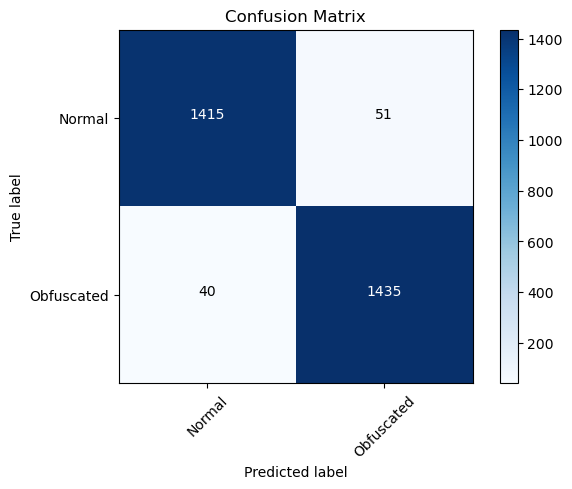

In [6]:
# see how the model performs against the test set
helpers.evaluate_model("Revoke-Obfuscation LR", lr, X_test, y_test)

## Logistic Regression Model Evaluation

In [7]:
lr_pipelines = {
    'lr_ss' : make_pipeline(StandardScaler(), LogisticRegression()),
    'lr_mm' : make_pipeline(MinMaxScaler(), LogisticRegression()),
    'l1_ss' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1')),
    'l1_mm' : make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l1')),
    'l2_ss' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2')),
    'l2_mm' : make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2')),
    'elasticnet_ss' : make_pipeline(StandardScaler(), LogisticRegression(penalty='elasticnet')),
    'elasticnet_mm' : make_pipeline(MinMaxScaler(), LogisticRegression(penalty='elasticnet'))
}

lrbase_hyperparameters = {
    'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
    'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

l1_hyperparameters = {
    'logisticregression__solver' : ['liblinear', 'saga'],
    'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

l2_hyperparameters = {
    'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
    'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

elasticnet_hyperparameters = {
    'logisticregression__solver' : ['saga'],
    'logisticregression__l1_ratio' : [0.2, 0.4, 0.6, 0.8],
    'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lr_hyperparameters = {
    'lr_ss' : lrbase_hyperparameters,
    'lr_mm' : lrbase_hyperparameters,
    'l1_ss' : l1_hyperparameters,
    'l1_mm' : l1_hyperparameters,
    'l2_ss' : l2_hyperparameters,
    'l2_mm' : l2_hyperparameters,
    'elasticnet_ss' : elasticnet_hyperparameters,
    'elasticnet_mm' : elasticnet_hyperparameters
}

In [8]:
fit_lr_models = {}

for name, pipeline in lr_pipelines.items():

    print(f"Fitting: {name}")

    model = RandomizedSearchCV(pipeline, lr_hyperparameters[name], cv=5, n_jobs=-1)
    
    fit_lr_models[name] = helpers.train_model(model, X_train_boruta_shap, y_train)

Fitting: lr_ss
Fitting: lr_mm
Fitting: l1_ss


: 

In [9]:
print(f"Model\tScore\t\t\tTraining Time")

for key,value in fit_lr_models.items():
    print(f"{key}\t{value[0].best_score_}\t{value[1]}")

Model	Score			Training Time
lr_ss	0.9717712010431032	32.667474031448364
lr_mm	0.9739818324269784	50.01861214637756
l1_ss	0.9739818685655308	1139.4924743175507
l1_mm	0.974746849441009	794.9837880134583
l2_ss	0.974066866440584	39.297502756118774
l2_mm	0.9746618154274035	26.00521945953369
elasticnet_ss	0.9546811350974729	64.55295538902283
elasticnet_mm	0.9746618154274035	45.175251960754395


In [10]:
pickle.dump(fit_lr_models, open("lr_models_boruta_shap.bin", "wb"))

In [11]:
best_l2 = fit_lr_models['l2_mm'][0]
print(f"Best L2 estimator         : {best_l2.best_estimator_}")
print(f"Best L2 score             : {best_l2.best_score_}")

best_en = fit_lr_models['elasticnet_mm'][0]
print(f"Best ElasticNet estimator : {best_en.best_estimator_}")
print(f"Best ElasticNet score     : {best_en.best_score_}")

Best L2 estimator         : Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, solver='saga'))])
Best L2 score             : 0.9746618154274035
Best ElasticNet estimator : Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1000, l1_ratio=0.8, penalty='elasticnet',
                                    solver='saga'))])
Best ElasticNet score     : 0.9746618154274035


## Model Tuning

#### Now we perform a hyperparameter grid search to do more fine-tuning before evaluating on the test set.

In [12]:
l2_params = [{'logisticregression__C': [.1, 1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000, 1250, 1500]}]

l2_pipe = make_pipeline( MinMaxScaler(), LogisticRegression(solver='saga', penalty='l2') )

l2_search = GridSearchCV( l2_pipe,
                          param_grid=l2_params,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1,
                          verbose=True)

start_time = time.time()
l2_search.fit(X_train_boruta_shap, y_train)
print(f"Fit in: {time.time() - start_time} seconds")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fit in: 45.63982582092285 seconds


In [13]:
print(f"Best estimator : {l2_search.best_estimator_}")
print(f"Best params    : {l2_search.best_params_}")
print(f"Best score     : {l2_search.best_score_}")

Best estimator : Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(C=5, solver='saga'))])
Best params    : {'logisticregression__C': 5}
Best score     : 0.9749169897453245


In [14]:
en_hyperparameters = {
    'logisticregression__l1_ratio' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'logisticregression__C' : [1, 10, 50, 100, 250, 500, 750, 1000, 1250, 1500]
}

en_pipe = make_pipeline( MinMaxScaler(), LogisticRegression(solver='saga', penalty='elasticnet') )

en_search = GridSearchCV( en_pipe,
                          param_grid=en_hyperparameters,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1,
                          verbose=True)

start_time = time.time()
en_search.fit(X_train_boruta_shap, y_train)
print(f"Fit in: {time.time() - start_time} seconds")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Fit in: 457.3099195957184 seconds


In [15]:
print(f"Best estimator : {en_search.best_estimator_}")
print(f"Best params    : {en_search.best_params_}")
print(f"Best score     : {en_search.best_score_}")

Best estimator : Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1250, l1_ratio=0.7, penalty='elasticnet',
                                    solver='saga'))])
Best params    : {'logisticregression__C': 1250, 'logisticregression__l1_ratio': 0.7}
Best score     : 0.9748318834546144


#### Final Tuned LR Model Evaluation

The best performing models were the MinMaxScaled variants, with the following model winning out performance wise as well as in regards to training time:
    
`LogisticRegression(C=5, solver='saga')`

Let's first retrain a fresh model with these hyperparamters and then see how it performs against the final test set:

In [17]:
tuned_pipeline = make_pipeline( MinMaxScaler(), LogisticRegression(penalty='l2', solver='saga', C=5) )
start_time = time.time()
tuned_pipeline.fit(X_train_boruta_shap, y_train)
print(f"Fit in: {time.time() - start_time} seconds")

Fit in: 5.883082628250122 seconds



===== LR (Ridge/L2) =====

   Accuracy (test) : 0.9786
   F1       (test) : 0.9784
   AUROC    (test) : 0.9939



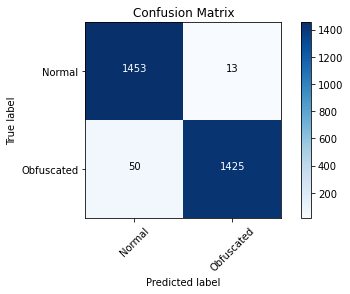

In [19]:
helpers.evaluate_model("LR (Ridge/L2)", tuned_pipeline, X_test_boruta_shap, y_test)

In [20]:
# save off the tuned model
pickle.dump(tuned_pipeline, open("../models/tuned_ridge.bin", "wb"))

## Observations

The Lasso/L1, Ridge/L2, and ElasticNet regularized LogisticRegression models with MinMax scaling were all extremely close in accuracy. However, the Ridge model was siginificantly faster to train than the other families.

Tuning values of C for the Ridge model produced a small increase in accuracy, with the final accuracy on the test (97.86%) set actually out performing the cross-validated accuracy on the training set (97.48%). Also notable was the fairly small number of false positives, 14 total of 2491 samples. All of these statistics outperform the original Revoke-Obfuscation model while simultaneously using about 1/10th of the original features for training.

| Algorithm                              | Dataset     | Test Accuracy |
|----------------------------------------|-------------|---------------|
| Revoke-Obfuscation Logistic Regression | All         | 96.91%        |
| Tuned Ridge/L2 Logistic Regression     | Boruta-Shap | 97.86%        |